In [2]:
import numpy as np
import matplotlib.pyplot as plt 

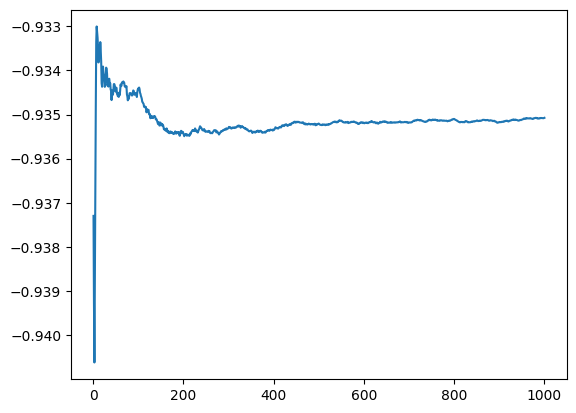

In [27]:
data=np.loadtxt("ISING_1D/output.ene.0")
plt.errorbar(data[:,0],data[:,2],label="pippo")
plt.show()